In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
def split(df, label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

In [3]:
def initilization_of_population(size, n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat, dtype=np.bool)     
        chromosome[:int(0.3 * n_feat)] = False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

In [4]:
def fitness_score(population, X_train, Y_train, X_test, Y_test, model):
    scores = []
    for chromosome in population:
        model.fit(X_train.iloc[:, chromosome], Y_train)         
        predictions = model.predict(X_test.iloc[:, chromosome])
        scores.append(accuracy_score(Y_test, predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                    
    return list(scores[inds][::-1]), list(population[inds][:][::-1]) 

In [5]:
def selection(pop_after_fit, n_parents):
    return pop_after_fit[:n_parents]

In [6]:
def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel.copy()
    for i in range(0, len(pop_after_sel), 2):
        if i + 1 < len(pop_after_sel):
            child_1, child_2 = pop_after_sel[i], pop_after_sel[i + 1]
            crossover_point = randint(1, len(child_1) - 1)
            child_1[crossover_point:], child_2[crossover_point:] = child_2[crossover_point:], child_1[crossover_point:]
            pop_nextgen.extend([child_1, child_2])
    return pop_nextgen

In [7]:
def mutation(pop_after_cross, mutation_rate, n_feat):
    mutation_range = int(mutation_rate * n_feat)
    pop_next_gen = []
    for chromo in pop_after_cross:
        chromo = chromo.copy()
        for _ in range(mutation_range):
            pos = randint(0, n_feat - 1)
            chromo[pos] = not chromo[pos]
        pop_next_gen.append(chromo)
    return pop_next_gen

In [8]:
def generations(df, label, size, n_feat, n_parents, mutation_rate, n_gen, X_train, X_test, Y_train, Y_test, model):
    best_chromo = []
    best_score = []
    population_nextgen = initilization_of_population(size, n_feat)
    best_overall_score = 0
    best_overall_chromo = None
    
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen, X_train, Y_train, X_test, Y_test, model)
        
        if scores[0] > best_overall_score:
            best_overall_score = scores[0]
            best_overall_chromo = pop_after_fit[0]
        else:
            scores[0] = best_overall_score
            pop_after_fit[0] = best_overall_chromo
        
        print(f'Best score in generation {i + 1}: {scores[0]}')
        print(f'Best chromosome in generation {i + 1}: {pop_after_fit[0].astype(int)}')  # Print the best chromosome
        
        pop_after_sel = selection(pop_after_fit, n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross, mutation_rate, n_feat)
        
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
        
    return best_chromo, best_score, best_overall_chromo


In [9]:
# Initialize classifiers
classifiers = {
    'LinearSVM': SVC(kernel='linear'),
    'RadialSVM': SVC(kernel='rbf'),
    'Logistic': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=0),
    'AdaBoost': AdaBoostClassifier(random_state=0),
    'DecisionTree': DecisionTreeClassifier(random_state=0),
    'KNeighbors': KNeighborsClassifier(),
    'GradientBoosting': GradientBoostingClassifier(random_state=0)
}

In [10]:
# Load dataset
data_bc = pd.read_csv("data.csv")
label_bc = data_bc["diagnosis"]
label_bc = np.where(label_bc == 'M', 1, 0)
data_bc.drop(["id", "diagnosis", "Unnamed: 32"], axis=1, inplace=True)

In [11]:
# Split dataset
X_train, X_test, Y_train, Y_test = split(data_bc, label_bc)


In [12]:
# Dictionary to store accuracy of each classifier
accuracy_dict = {}

In [13]:
# Run Genetic Algorithm for feature selection and train each classifier
for name, clf in classifiers.items():
    print(f"\nRunning Genetic Algorithm for {name}")
    _, _, best_chromo = generations(data_bc, label_bc, size=80, n_feat=data_bc.shape[1], n_parents=64, mutation_rate=0.20, n_gen=5,
                                     X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test, model=clf)
    
    # Train classifier with the best chromosome
    clf.fit(X_train.iloc[:, best_chromo], Y_train)
    predictions = clf.predict(X_test.iloc[:, best_chromo])
    accuracy = accuracy_score(Y_test, predictions)
    accuracy_dict[name] = accuracy
    print(f"Accuracy for {name}: {accuracy}")


Running Genetic Algorithm for LinearSVM
Best score in generation 1: 0.993006993006993
Best chromosome in generation 1: [1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1]
Best score in generation 2: 0.993006993006993
Best chromosome in generation 2: [1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1]
Best score in generation 3: 0.993006993006993
Best chromosome in generation 3: [1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0]
Best score in generation 4: 0.993006993006993
Best chromosome in generation 4: [1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 1 0]
Best score in generation 5: 0.993006993006993
Best chromosome in generation 5: [1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0]
Accuracy for LinearSVM: 0.986013986013986

Running Genetic Algorithm for RadialSVM
Best score in generation 1: 0.965034965034965
Best chromosome in generation 1: [1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0]
Best score in generation 2: 0.

d:\genetic\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\genetic\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opt

Best score in generation 1: 0.986013986013986
Best chromosome in generation 1: [1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 1]


d:\genetic\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\genetic\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opt

Best score in generation 2: 0.993006993006993
Best chromosome in generation 2: [1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 1 1 1 1 1]


d:\genetic\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\genetic\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opt

Best score in generation 3: 0.993006993006993
Best chromosome in generation 3: [1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 1 1 1 1 0]


d:\genetic\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\genetic\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opt

Best score in generation 4: 0.993006993006993
Best chromosome in generation 4: [1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0]


d:\genetic\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\genetic\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opt

Best score in generation 5: 0.993006993006993
Best chromosome in generation 5: [1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0]
Accuracy for Logistic: 0.986013986013986

Running Genetic Algorithm for RandomForest
Best score in generation 1: 0.993006993006993
Best chromosome in generation 1: [0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0]
Best score in generation 2: 0.993006993006993
Best chromosome in generation 2: [0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1]
Best score in generation 3: 1.0
Best chromosome in generation 3: [1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1]
Best score in generation 4: 1.0
Best chromosome in generation 4: [1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1]
Best score in generation 5: 1.0
Best chromosome in generation 5: [1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1]
Accuracy for RandomForest: 0.986013986013986

Running Genetic Algorithm for AdaBoost


d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\skle

Best score in generation 1: 0.9790209790209791
Best chromosome in generation 1: [1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0]


d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\skle

Best score in generation 2: 0.993006993006993
Best chromosome in generation 2: [1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 0 0 1 1]


d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\skle

Best score in generation 3: 0.993006993006993
Best chromosome in generation 3: [1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 1]


d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\skle

Best score in generation 4: 0.993006993006993
Best chromosome in generation 4: [1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0 1]


d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\genetic\.conda\Lib\site-packages\skle

Best score in generation 5: 0.993006993006993
Best chromosome in generation 5: [1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0]
Accuracy for AdaBoost: 0.965034965034965

Running Genetic Algorithm for DecisionTree


d:\genetic\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best score in generation 1: 0.965034965034965
Best chromosome in generation 1: [1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1]
Best score in generation 2: 0.965034965034965
Best chromosome in generation 2: [1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1]
Best score in generation 3: 0.993006993006993
Best chromosome in generation 3: [0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1]
Best score in generation 4: 0.993006993006993
Best chromosome in generation 4: [0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1]
Best score in generation 5: 0.993006993006993
Best chromosome in generation 5: [0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 1]
Accuracy for DecisionTree: 0.951048951048951

Running Genetic Algorithm for KNeighbors
Best score in generation 1: 0.965034965034965
Best chromosome in generation 1: [1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0]
Best score in generation 2: 0.972027972027972
Best chromosome in ge

C:\Users\thienng23\AppData\Local\Temp\ipykernel_17476\3961339323.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracy_dict.keys()), y=list(accuracy_dict.values()), palette='viridis')


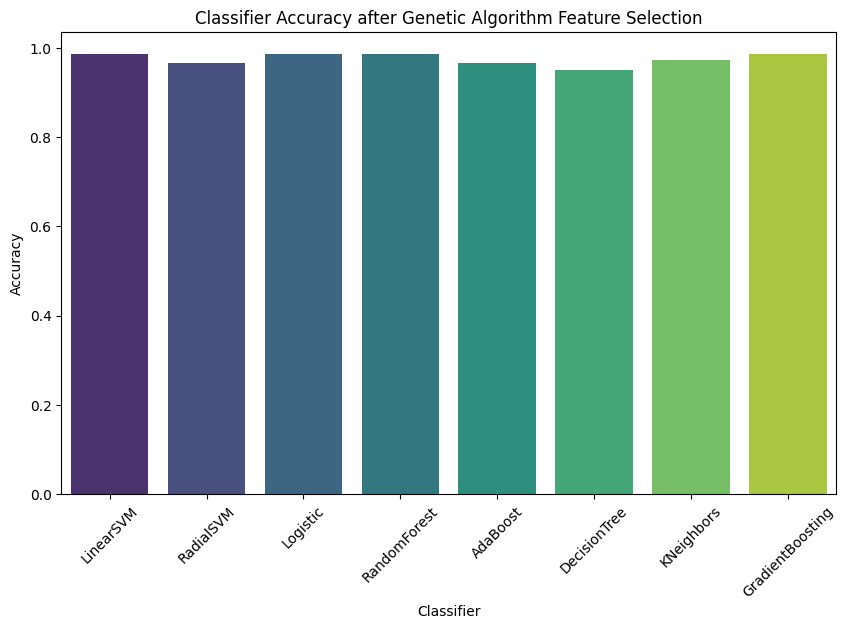

In [14]:
# Plot the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracy_dict.keys()), y=list(accuracy_dict.values()), palette='viridis')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy after Genetic Algorithm Feature Selection')
plt.xticks(rotation=45)
plt.show()